In [6]:
import scipy as sp
import numpy as np

!pip install -e git+https://github.com/harrispirie/stmpy.git#egg=stmpy
import stmpy
import stmpy.driftcorr as dfc
%pylab inline

Obtaining stmpy from git+https://github.com/harrispirie/stmpy.git#egg=stmpy
  Updating ./src/stmpy clone
  Running command git fetch -q --tags
  Running command git reset --hard -q a1cce8d48d66f44085b154e351bb6560fad1cb61
  Found existing installation: stmpy 0.1
    Uninstalling stmpy-0.1:
      Successfully uninstalled stmpy-0.1
  Running setup.py develop for stmpy


ModuleNotFoundError: No module named 'stmpy'

In [48]:
# quick_display function
def quick_display(A, sigma=3):
    A_fft = stmpy.tools.fft(A, zeroDC=True)
    L = np.shape(A)[-1]
    c = np.mean(A_fft)
    s = np.std(A_fft)
    fig,ax=plt.subplots(2,2,figsize=[8, 8])
    ax[0, 0].imshow(A, cmap=stmpy.cm.blue2, origin='lower')
    ax[0, 0].axhline(L/2, color='r', linestyle='--')
    ax[0, 1].imshow(A_fft, cmap=stmpy.cm.gray_r, origin='lower', clim=[0,c+sigma*s])
    ax[0, 1].axhline(L/2, color='b', linestyle='--')
    ax[1, 0].plot(A[int(L/2)], 'r')
    ax[1, 0].plot(A[int(L/2)], 'rx', ms=4, mew=1)   
    ax[1, 1].plot(A_fft[int(L/2)], 'b')
    ax[1, 1].plot(A_fft[int(L/2)], 'bx', ms=4, mew=1) 

# generate impurity function
def generate_map(size, L, a0):
    s = linspace(0, size, L)
    x, y = meshgrid(s[:-1], s[:-1])
    k0 = 2*pi/a0
    z0 = cos(k0 * x) * cos(k0 * y)
    return z0

# add impurity function
def add_imp(A, size, center=None, decay=None, a=None, ratio=None, itype='0', ):
    L = shape(A)[-1]
    s = linspace(0, size, L)
    x, y = meshgrid(s, s)
    if itype == '0':
        k = 2*pi / a
        r = sqrt((x-center[0])**2+(y-center[1])**2)
        z1 = exp(-decay * r) * sin(k * r)
        return A + z1
    elif itype == '1':
        k = 2*pi / a
        r = sqrt((x-center[0])**2+(y-center[1])**2)
        r_x = sqrt(ratio*(x-center[0])**2+(y-center[1])**2)
        r_y = sqrt((x-center[0])**2+ratio*(y-center[1])**2)
    
        z2 = (exp(-decay * r) * sin(k * r_x) +\
         exp(-decay * r) * sin(k * r_y)) / 2
        return A + z2
    elif itype == '2':
        r = sqrt((x-center[0])**2+(y-center[1])**2)
        z3 = exp(-decay * r**2)
        return A + z3
    elif itype == '3':
        r = sqrt((x-center[0])**2+(y-center[1])**2)
        r_x = sqrt(ratio*(x-center[0])**2+(y-center[1])**2)
        r_y = sqrt((x-center[0])**2+ratio*(y-center[1])**2)
    
        z4 = (exp(-decay * r_x) +\
             exp(-decay * r_y)) / 2
        return A + z4
    else:
        print("Error: please input itype as one of '0', '1', '2', '3'.")

In [3]:
def quick_show_single(A, en, thres=5, rspace=False, saveon=False, imgName=''):
    # to fold
    # Quick show single images  
    layers = len(A)
    if rspace is False:
        imgsize = np.shape(A)[-1]
        bp_x = np.min(dfc.findBraggs(np.mean(A, axis=0), min_dist=int(imgsize/10), rspace=rspace))
        ext = imgsize / (imgsize - 2*bp_x)
    
    for i in range(layers):
        plt.figure(figsize=[4,4])
        c = np.mean(A[i])
        s = np.std(A[i])
        if rspace is True:
            plt.imshow(A[i], clim=[c-thres*s,c+thres*s],cmap=stmpy.cm.jackyPSD)
        else:
            plt.imshow(A[i],extent=[-ext,ext,-ext,ext,],clim=[0,c+thres*s],cmap=stmpy.cm.gray_r)
            plt.xlim(-1.2,1.2)
            plt.ylim(-1.2,1.2)
        stmpy.image.add_label("${}$mV".format(int(en[i])), ax=plt.gca())
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().set_frame_on(False)
        if saveon is True:
            plt.savefig("{} at ${}$mV.png".format(imgName, int(en[i])),dpi=200, bbox_inches='tight',pad_inches=0)
def zero_mask(A, coord, width1=8, width2=8):
    B = copy(A)
    for ix in coord:
        B[ix[0]-width1:ix[0]+width1,ix[1]-width2:ix[1]+width2] = 0
        B[ix[0]-width2:ix[0]+width2,ix[1]-width1:ix[1]+width1] = 0
    return B
def kill_lattice1(img, show=False, thres2 = 0.85):
    
    import scipy.io as sio
    
    bp_a1 = dfc.findBraggs(img, show=show)

    A1_fft = fft.fftshift(fft.fft2(img))
    
    b = zero_mask(real(A1_fft), coord=bp_a1, width1=3,width2=3) + \
        1j*zero_mask(imag(A1_fft), coord=bp_a1, width1=3,width2=3)
    
    z_inv1 = fft.ifft2(fft.ifftshift(b))

    killed = real(z_inv1)

    z_new = stmpy.tools.lineSubtract(killed, 2, maskon=True, thres=3)

    return killed, z_new
def kill_lattice2(img, show=False, thres2 = 0.85):
    
    import scipy.io as sio
    
    bp_a1 = dfc.findBraggs(img, show=show)

    A1_fft = fft.fftshift(fft.fft2(img))
    
    b = zero_mask(real(A1_fft), coord=bp_a1, width1=3,width2=3) + \
        1j*zero_mask(imag(A1_fft), coord=bp_a1, width1=3,width2=3)
    
    z_inv1 = fft.ifft2(fft.ifftshift(b))
    
    other_pts = dfc.findBraggs(real(z_inv1),rspace=True,show=show,maskon=False, maskon2 = True, thres=thres2)
    
    c = zero_mask(real(b), coord=other_pts, width1=3,width2=3) + \
        1j*zero_mask(imag(b), coord=other_pts, width1=3,width2=3)
    
    #figure()
    #imshow(real(c)+imag(c), clim=(0,2e-10))
    
    z_inv2 = fft.ifft2(fft.ifftshift(c))

    killed = real(z_inv2)

    z_new = stmpy.tools.lineSubtract(killed, 2, maskon=True, thres=3)

    return killed, z_new
def findBraggs(A, obj=None, rspace=True, min_dist=5, thres=0.25, gwidth=5, 
               maskon=True, maskon2=False, show=False, angle=0, update_obj=True):
    '''
    Find Bragg peaks in the unit of pixels of topo or FT pattern A using peak_local_max. If obj is offered,
    an attribute of bp will be created for obj.

    Input: 
        A           - Required : 2D array of topo in real space, or FFT in q space.
        obj         - Optional : Object associated with A
        min_dist    - Optional : Minimum distance (in pixels) between peaks. Default: 5
        thres       - Optional : Minimum intensity of Bragg peaks relative to max value. Default: 0.25
        rspace      - Optional : Boolean indicating if A is real or Fourier space image. Default: True
        gwidth      - Optional : width of the gaussian ring to preserve Bragg peaks
        maskon      - Optional : Boolean, if True then a Gaussian mask (width=len(A)/5) will be used to 
                                    remove low q high intensity signals before finding Bragg peaks.
        show        - Optional : Boolean, if True then A and Bragg peaks will be plotted out.
        update_obj  - Optional : Boolean, if True then all the attributes of the object will be updated.

    Returns:
        coords      -  (4x2) array contains Bragg peaks in the format of [[x1,y1],[x2,y2],...,[x4,y4]]

    Usage:
        import stmpy.driftcorr as dfc
        bp = dfc.findBraggs(A, obj=topo, min_dist=10, thres=0.2, rspace=True, show=True)

    History:
        04/28/2017      JG : Initial commit.
        04/29/2019      RL : Add maskon option, add outAll option, and add documents.

    '''
    if rspace is True:
        F = stmpy.tools.fft(A, zeroDC=True)
    else:
        F = np.copy(A)
    # Remove low-q high intensity data with Gaussian mask
    if maskon is True:
        X, Y = np.shape(A)
        Lx = X/5
        Ly = Y/5
        x = np.arange(X)
        y = np.arange(Y)
        p0 = [int(X/2), int(Y/2), Lx, Ly, 1, np.pi/2]
        G = 1-stmpy.tools.gauss2d(x, y, p=p0)
        if angle is 0:
            mask3 = np.ones([X, Y])
            mask3[X//2-X//10:X//2+X//10,:] = 0
            mask3[:,Y//2-Y//10:Y//2+Y//10] = 0
        else: 
            mask3 = 1
        F *= G * mask3
        if obj is not None:
            L = np.shape(A)[-1]
            x = np.arange(L)
            y = np.arange(L)
            mask2 = stmpy.tools.gauss_ring(x, y, major=obj.qmag, minor=obj.qmag,
                                   sigma=obj.qmag / gwidth, x0=L/2, y0=L/2)
            F *= mask2*mask3
    
    if maskon2 is True:
        X, Y = np.shape(A)
        Lx = X/5
        Ly = Y/5
        x = np.arange(X)
        y = np.arange(Y)
        p0 = [int(X/2), int(Y/2), Lx, Ly, 1, np.pi/2]
        G = 1-stmpy.tools.gauss2d(x, y, p=p0)
        F *= G
        
    cnorm = mpl.colors.Normalize(vmin=F.min(), vmax=F.max())
    coords = peak_local_max(F, min_distance=min_dist, threshold_rel=thres)
    coords = np.fliplr(coords)
    if show is True:
        plt.figure(figsize=[4,4])
        plt.imshow(F, cmap=plt.cm.gray_r, interpolation='None', origin='lower left', norm=cnorm, aspect=1)
        plt.plot(coords[:, 0], coords[:, 1], 'r.')
        plt.gca().set_aspect(1)
        plt.axis('tight')
        print('#:\t[x y]')
        for ix, iy in enumerate(coords):
            print(ix, end='\t')
            print(iy)
    if obj is not None:
        if update_obj is True:
            obj.bp = coords
    return coords
def remove_impurity(img, show=True, thres = 0.8, denoise_const = 4, bpsets=2):
    img_fft = stmpy.tools.fft(img, zeroDC=True)
    
    if bpsets == 1:
        x, cor = kill_lattice1(img, show = show, thres2 = thres)
    if bpsets == 2:
        x, cor = kill_lattice2(img, show = show, thres2 = thres)
    if show:
        figure()
        fig, ax =subplots(1,3,figsize=(22,4))
        ax[0].imshow(img)
        ax[0].set_title('Raw image')
        stmpy.image.add_colorbar(ax=ax[0], ticks=True, loc=1)
        ax[1].imshow(x)
        ax[1].set_title('Bragg peaks eliminated')
        stmpy.image.add_colorbar(ax=ax[1], ticks=True, loc=1)
        ax[2].imshow(cor)
        ax[2].set_title('BP Gone and Line Subtracted')
        stmpy.image.add_colorbar(ax=ax[2], ticks=True, loc=1)
    
    min_before = amin(x)
    max_before = amax(x)

    rescaled = ((x-amin(x))/(amax(x)-amin(x))*255).astype('uint8')
    
    import cv2
    dst = cv2.fastNlMeansDenoising(rescaled,None,denoise_const,13)

    
    if show:
        figure()
        plot(rescaled[len(rescaled)//2])
        plot(dst[len(dst)//2], c='r')
        title('Linecut across impurity')
    
    sub_mean = copy(dst)-0.0

    sub_fft = stmpy.tools.fft(sub_mean, zeroDC=True)
    r1, cut1 = dfc.quick_linecut(sub_fft, width=8)
    qm1 = linspace(-r1, r1, shape(cut1[0])[-1])
    qx1 = linspace(-r1*sqrt(2), r1*sqrt(2), shape(cut1[-1])[-1])

    if show:
        fig, ax = subplots(1,2,figsize=(15,6))
        ax[0].imshow(img)
        ax[0].set_title('Original DoS image')
        stmpy.image.add_colorbar(ax=ax[0], ticks=True, loc=1)
        ax[1].imshow(sub_mean)
        ax[1].set_title('Isolated impurity')
        stmpy.image.add_colorbar(ax=ax[1], ticks=True, loc=1)
    
    rescale = np.interp(sub_mean, (sub_mean.min(), sub_mean.max()), (min_before, max_before))
          
    subtract = img-rescale+mean(rescale)
    
    if show:
        figure()
        imshow(subtract)
        title('Impurity removed in R-space')
        dfc.display(img, subtract)
        figure()
        plot(stmpy.tools.fft(img)[len(img)//2-5])
        plot(stmpy.tools.fft(subtract)[len(subtract)//2-5], c='r')
        title('Linecut across middle of FFT of both')

    return subtract#, mid_linecuts, dia_linecuts
def remove_mult_impurities(mult_imgs, show = False, denoise_const = 4, bpsets=2):
    removed = []
    tot = len(mult_imgs)
    for a in range(len(mult_imgs)):
        removed.append(remove_impurity(mult_imgs[a], show=show, denoise_const=denoise_const, bpsets=bpsets))
        progress = int((a+1)/tot * 100)
        print(str(progress) + '%', end='\r')
    return removed
def circ_crop(A, rem, startpt, r):
    
    '''
    INPUTS:
 
        A       : DoS map containing ALL impurities
        rem     : Map with impurities removed
        startpt : Center of impurity in the form (h,k)
        r       : Radius of circular crop around impurity
        
    RETURNS:
    
        added   : Array containing the lattice with one impurity 
    
    '''
    
    if len(A.shape)==2:
        L = A.shape[0]
        s = arange(L)
        x,y = meshgrid(s,s)
        h,k = startpt[0], startpt[1]
        coords = array(where((x-h)**2+(y-k)**2 < r**2))
        ct = coords.T
        crop = zeros((L,L))
        other = copy(rem)

        for b in range(len(ct)):
            crop[ct[b,0], ct[b,1]] = A[ct[b,0],ct[b,1]]
            other[ct[b,0], ct[b,1]]  = 0
        
    if len(A.shape)==3:
        L = A.shape[1]
        s = arange(L)
        x,y = meshgrid(s,s)
        h,k = startpt[0], startpt[1]
        coords = array(where((x-h)**2+(y-k)**2<r**2))
        ct = coords.T
        print(ct.shape)
        crop = zeros((len(A), L,L))
        other = copy(rem)

        for a in range(len(A)):
            for b in range(len(ct)):
                crop[a,ct[b,0], ct[b,1]] = A[a,ct[b,0],ct[b,1]]
                other[a,ct[b,0], ct[b,1]]  = 0
    added = crop + other
    return added
def edge_function(A, dos, lattice, R, startpt, width):
    A_new = copy(A)
    phi = 1/R
    theta = 0.0
    thetas = []
    
    h=startpt[0]
    k=startpt[1]
    while theta < 2*pi:
        thetas.append(theta)
        theta += phi
        #print('New theta : ' + str(theta))
    #pset = []
    
    
    for t in range(len(thetas)):
        #print('Theta updated! New theta : ' + str(thetas[t]))
        for a in range(2*width):
            r = R-width+a
            r_new = a
            point = pt(r, thetas[t])
            pt_on_img = (h+point[0], k+point[1])
            point_new = pt(r, thetas[t])
            #print('Point : ' + str(pt_on_img))
            alpha = a/(2*width)
            newval = (lattice[pt_on_img]*alpha+(1-alpha)*dos[pt_on_img])
            
            #print(lattice[pt_on_img], dos[pt_on_img], newval, alpha)
            A_new[pt_on_img] = newval

    return A_new
def pt(r,theta):
    x = int(r*cos(theta))
    y=int(r*sin(theta))
    return x, y
def checkmean(final_img, startpt, w1, w2=3):
    h=startpt[0]; k=startpt[1]
    mean1 = []
    mean2 = []
    t = copy(final_img)
    mean1.append(mean(final_img[h-w1-w2:h-w1, k-w1-w2:k+w1]))
    mean1.append(mean(final_img[h-w1:h+w1+w2, k-w1-w2:k-w1]))
    mean1.append(mean(final_img[h+w1:h+w1+w2, k-w1:k+w1+w2]))
    mean1.append(mean(final_img[h-w1-w2:h+w1, k+w1:k+w1+w2]))

    mean2.append(mean(final_img[h-w1:h-w1+w2, k-w1:k+w1-w2]))
    mean2.append(mean(final_img[h-w1+w2:h+w1, k-w1:k-w1+w2]))
    mean2.append(mean(final_img[h+w1-w2:h+w1, k-w1+w2:k+w1]))
    mean2.append(mean(final_img[h-w1:h+w1-w2, k+w1-w2:k+w1]))

    t[h-w1-w2:h-w1, k-w1-w2:k+w1]=1
    t[h-w1:h+w1+w2, k-w1-w2:k-w1]=1
    t[h+w1:h+w1+w2, k-w1:k+w1+w2]=1
    t[h-w1-w2:h+w1, k+w1:k+w1+w2]=1
    t[h-w1:h-w1+w2, k-w1:k+w1-w2]=-1
    t[h-w1+w2:h+w1, k-w1:k-w1+w2]=-1
    t[h+w1-w2:h+w1, k-w1+w2:k+w1]=-1
    t[h-w1:h+w1-w2, k+w1-w2:k+w1]=-1
    
    diff = mean(mean2) - mean(mean1)
    
    print(diff)
    final_test = copy(final_img)
    final_test[:h-w1]+=diff*1
    final_test[h+w1:]+=diff*1
    final_test[h-w1:h+w1,:k-w1]+=diff*1
    final_test[h-w1:h+w1,k+w1:]+=diff*1

    return final_test
def gauss_edge_function(A, dos, lattice, R, startpt):
    x = arange(A.shape[0])
    y = arange(A.shape[1])
    k=startpt[0]
    h=startpt[1]
    
    g1=stmpy.tools.gauss2d(x,y,[h,k,R,R,1,0])
    g2 = 1-g1
    
    #fig, ax = subplots(1,2,figsize=(8,4))
    #ax[0].imshow(g1)
    #ax[1].imshow(g2)
    final = g1 * dos + g2*lattice
    imshow(g1)
    return final
def iso_cuts_noisemap(img):
    mid_linecuts_x=[]
    mid_linecuts_y=[]
    dia_linecuts_x=[]
    dia_linecuts_y=[]
    print(amin(img), amax(img))

    for a in range(15):
        print(a)
        zrem = remove_impurity(img, bpsets=1,denoise_const=a, show=False)
        imshow(zrem)
        stmpy.image.add_colorbar(ticks=True, loc=1)
        title('MAP')
        zrem_fft = stmpy.tools.fft(zrem,zeroDC=True)
        print(mean(zrem_fft))
        r1, cut1 = dfc.quick_linecut(zrem_fft, width=8)
        print(mean(cut1[0]))
        qm1 = linspace(-r1, r1, shape(cut1[0])[-1])
        qx1 = linspace(-r1*sqrt(2), r1*sqrt(2), shape(cut1[-1])[-1])
        mid_linecuts_x.append(qm1)
        mid_linecuts_y.append(cut1[0])
        dia_linecuts_x.append(qx1)
        dia_linecuts_y.append(cut1[-1])
    return mid_linecuts_x, mid_linecuts_y, dia_linecuts_x, dia_linecuts_y

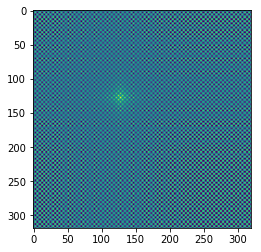

In [87]:
z0 = generate_map(50, 320, 1)
z1 = copy(z0)
x0=20; y0=20
z1 = add_imp(z1, 50, center=[x0, y0], decay=0.5, a=10, ratio=5, itype='3') 
imshow(z1)

(319, 319)

# Generating a dataset with corresponding widths # 

In [81]:
n = 10 # generate n QPI maps
qpis = []
points = []
widths=[]
gamma=320/50
for a in range(n):
    num = 4 
    pts = np.zeros((num, 2))
    x0 = random.random(num) * 50
    y0 = random.random(num) * 50

    for x in range(num):
        pts[x][0]=x0[x]*gamma-x0[x]//(20)
        pts[x][1]=y0[x]*gamma-y0[x]//(20)
    points.append(pts)
    z1=copy(z0)
    wtemp=[]
    for i in range(num):
        d1=random.randint(20,80)/100
        d2=random.randint(20,80)/100
        d3=random.randint(20,80)/100
        
        '''
        for tpe in np.random.randint(0,4,(4,)):
            z1 = add_imp(z1, 50, center=[x0[i], y0[i]], decay=d1, a=10, ratio=5, itype=f'{tpe}')
        '''
        
        # Add 4-fold symmetric impurity center
        z1 = add_imp(z1, 50, center=[x0[i], y0[i]], decay=d1, a=10, ratio=5, itype='3')
        # Add circular QPI signal
        z1 = add_imp(z1, 50, center=[x0[i], y0[i]], decay=d2, a=10, ratio=5, itype='0')
        # Add splitting 4-fold symmetric QPI signal
        z1 = add_imp(z1, 50, center=[x0[i], y0[i]], decay=d3, a=4, ratio=5, itype='1') 
        z1 = add_imp(z1, 50, center=[x0[i], y0[i]], decay=d3, a=3.2, ratio=5, itype='1') 
        alpha=0.08
        w1=-log(alpha)/d2*gamma
        w2=-log(alpha)/d3*gamma
        w=max(w1,w2)
        wtemp.append(w)
        #print(w1, w2, w1/w2, w)
    # Add overall noise
    noise = random.random(shape(z1)) * 0.5
    z1 = z1 + noise
    widths.append(wtemp)
    qpis.append(z1)

57.0
(29.60839539284055, -53.82656228485758)
41.0
(227.38869829359743, 22.735898317794124)
53.0
(47.350457675618586, 102.4099539121961)
20.0
(100.68095294740834, 176.55087857933677)


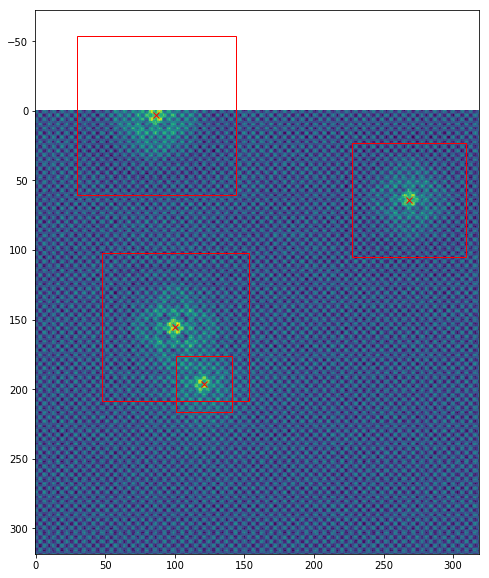

In [82]:
# Compare 1 and 7
import matplotlib.patches as patches
p=5
fig,ax=subplots(1,1,figsize=(10,10))
ax.imshow(qpis[p])
for a in range(len(points[p])):
    w=widths[p][a]//1; print(w)
    ax.plot(points[p][a][0],points[p][a][1], 'rx',ms=6,mew=1)
    pt = points[p][a][0]-w,points[p][a][1]-w
    print(pt)
    rect=patches.Rectangle((points[p][a][0]-w,points[p][a][1]-w),
                      2*w,2*w,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    

50.0
(251.17278265601448, -8.935031759817434)
44.0
(-16.87535236383039, 66.80545689593917)
22.0
(200.36615235084724, 76.15448320029144)
32.0
(-29.53432203390986, 235.74919315979116)


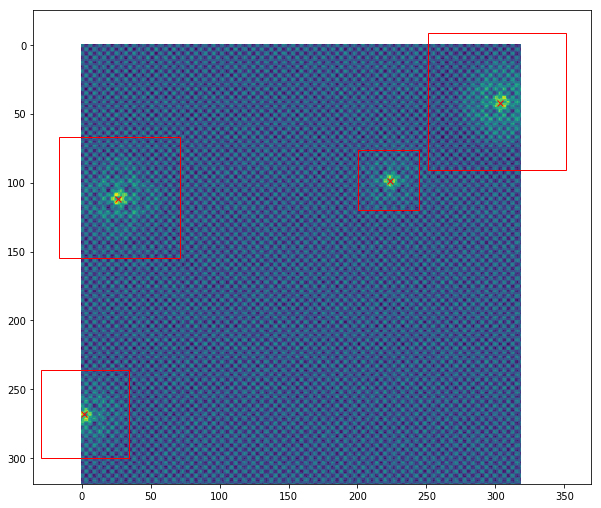

In [83]:
# Compare 1 and 7
import matplotlib.patches as patches
p=7
fig,ax=subplots(1,1,figsize=(10,10))
ax.imshow(qpis[p])
for a in range(len(points[p])):
    w=widths[p][a]//1; print(w)
    ax.plot(points[p][a][0]-1,points[p][a][1]-(points[p][a][1])//200, 'rx',ms=6,mew=1)
    pt = points[p][a][0]-(points[p][a][0])//100-w,points[p][a][1]-1-w
    print(pt)
    rect=patches.Rectangle((points[p][a][0]-(points[p][a][0])//100-w,points[p][a][1]-1-w),
                      2*w,2*w,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    

In [208]:
z0 = generate_map(50, 320, 1)
def generate_image():
    
    bboxes = []
    
    n = 10 # generate n QPI maps
    points = []
    widths=[]
    gamma=320/50
    
    num = 4 #This can be randomly selected. 
    pts = np.zeros((num, 2))

    x0 = random.random(num) * 50
    y0 = random.random(num) * 50

    #Rescale points to record.
    for x in range(num):

        pts[x][0]=x0[x]*gamma-x0[x]//(20)
        pts[x][1]=y0[x]*gamma-y0[x]//(20)

    #Record centers.
    points.append(pts)

    #grab lattice
    z1=copy(z0)

    #Stores widths for bboxes for image n.
    wtemp=[]
    #num = n_impurities
    for i in range(num):
        d1=random.randint(20,80)/100
        d2=random.randint(20,80)/100
        d3=random.randint(20,80)/100

        '''
        #Future random point generation: data augmentation.
        for tpe in np.random.randint(0,4,(4,)):
            z1 = add_imp(z1, 50, center=[x0[i], y0[i]], decay=d1, a=10, ratio=5, itype=f'{tpe}')
        '''
        # Add 4-fold symmetric impurity center
        z1 = add_imp(z1, 50, center=[x0[i], y0[i]], decay=d1, a=10, ratio=5, itype='3')
        # Add circular QPI signal
        z1 = add_imp(z1, 50, center=[x0[i], y0[i]], decay=d2, a=10, ratio=5, itype='0')
        # Add splitting 4-fold symmetric QPI signal
        z1 = add_imp(z1, 50, center=[x0[i], y0[i]], decay=d3, a=4, ratio=5, itype='1') 
        z1 = add_imp(z1, 50, center=[x0[i], y0[i]], decay=d3, a=3.2, ratio=5, itype='1') 
        alpha=0.08
        w1=-log(alpha)/d2*gamma
        w2=-log(alpha)/d3*gamma
        w=max(w1,w2)
        wtemp.append(w)

    # Add overall noise
    noise = random.random(shape(z1)) * 0.5
    z1 = z1 + noise
    z1 = np.interp(z1, (z1.min(), z1.max()), (0, 255))
    widths.append(wtemp)
    
    return z1, np.stack(points, axis=0)[0], np.stack(widths, axis=0).ravel()

In [154]:
def get_bboxes(p, w):
    bboxes = []
    for i,c in enumerate(p):
        xmin = c[0]-w[i]
        xmax = c[0]+w[i]
        ymin = c[1]-w[i]
        ymax = c[1]+w[i]
        box = [xmin, xmax, ymin, ymax]
        bboxes.append(box)
    return np.array(bboxes)

In [216]:
get_bboxes(p,w).astype(int)

array([[ 76, 157, 164, 245],
       [233, 331, 244, 342],
       [  0, 123, 145, 269],
       [ 39, 186, -22, 124]])

In [225]:
import PIL
from tqdm import tqdm
import os

!rm -rf keras-frcnn/train_imgs
!rm -rf keras-frcnn/test_imgs
!mkdir keras-frcnn/train_imgs
!mkdir keras-frcnn/test_imgs

a = numpy.asarray([ ['image_name','type', 'xmin', 'xmax', 'ymin', 'ymax'] ])
n = 100
test_pct = .2
rows = []
for a in tqdm(range(n)):
    z, p, w = generate_image()
    im = PIL.Image.fromarray(z)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    impath = None
    if a<(n*test_pct):
        #impath = os.path.join(os.path.abspath('.'),f'keras-frcnn/test_imgs/{a}.jpg')
        impath = f'test_imgs/{a}.jpg'
    else:
        #impath = os.path.join(os.path.abspath('.'),f'keras-frcnn/train_imgs/{a}.jpg')
        impath = f'train_imgs/{a}.jpg'
    
    im.save('keras-frcnn/'+impath)
    bboxes = get_bboxes(p,w).astype(int)
    for b in bboxes:
        rows.append([impath, 'imp']+list(b))
df = pd.DataFrame.from_records(rows)
df.columns = ['fpath', 'type', 'xmin', 'xmax', 'ymin', 'ymax']
df[['fpath', 'xmin', 'ymin', 'xmax','ymax','type']].to_csv('keras-frcnn/demo_input.txt', index=False, sep=',', header=None)


100%|██████████| 100/100 [00:07<00:00, 13.69it/s]


In [221]:
np.stack([z,z,z], axis=2).astype(int).shape

(319, 319, 3)

(319, 319, 3)

In [203]:
data = pd.read_csv('./demo_data.csv').iloc[:,1:]
data.columns = ['fpath', 'type', 'xmin', 'xmax', 'ymin', 'ymax']
data[['fpath', 'xmin', 'ymin', 'xmax','ymax','type']].to_csv('demo_input.txt', index=False, sep=' ', header=None)

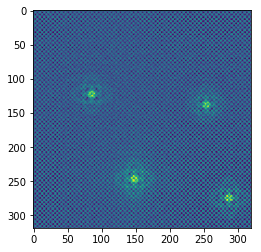

In [205]:
imshow(z)

In [207]:
new = np.interp(z, (z.min(), z.max()), (0, 255))


(255.0, 0.0)